# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계1 : 데이터 탐색

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * 한국어 처리
>> * [konlpy - 한국어 처리 라이브러리](https://konlpy.org/ko/latest/)
>> * [한국어 품사 태그 비교표](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)
>> * [한국어 품사 태깅 성능 비교](https://konlpy.org/ko/latest/morph/#comparison-between-pos-tagging-classes)
>> * [한국어 시스템 사전](https://konlpy.org/ko/latest/data/#corpora)

> * 자연어 처리
>> * [NLTK](https://www.nltk.org/book/)
>> * [gensim](https://radimrehurek.com/gensim/)
>> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-2)
>> * [WordCloud](https://amueller.github.io/word_cloud/)

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
# import matplotlib.pyplot as plt

# plt.rc('font', family='NanumBarunGothic') 

## 1. 개발 환경 설정

* 세부 요구사항
  - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
  - 필요하다고 판단되는 라이브러리를 추가하세요.
  - konlpy, mecab 설치 후 형태소 분석 함수 생성
  - mecab 설치할 때 윈도우 pc에서 설치는 다른 방법으로 진행
  - 윈도우 환경일 경우 KoNLPy의 라이브러리 설치가 제대로 이루어지지 않을 수 있습니다
  - 윈도우 설치를 위한 참고 링크
    - https://liveyourit.tistory.com/56

### 1-1. 라이브러리 설치

In [1]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.6/575.6 KB 30.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 14.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=4316c9f76d0edfe8921ff77f39a14b83231e402cb4221fc4407b48d492b285ca
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [2]:
!pip install --upgrade gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 48.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26527989 sha256=b95c7a55c9aec86db264a831f5fb84b63bdb531d122528b9c163bc9370bebe6a
  Stored in directory: /root/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


### 1-2. 라이브러리 import

In [36]:
import tensorflow as tf
import numpy as np
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

seed = 42
my_seed_everywhere(seed)

In [3]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter
import wget, os

### 1-4. 구글드라이브 연결(Colab)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.데이터 불러오기

* 주어진 데이터
 - 학습 및 검증용 데이터 : train.csv

### 2-1. 데이터 로딩

* 다음 데이터를 불러옵니다.
    * 학습 및 검증용 데이터 : train.csv
    * shape를 확인합니다.

In [5]:
data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/train.csv'
data = pd.read_csv(data_path)

In [6]:
data.shape

(3706, 2)

### 2-2. 데이터 확인하기
* 문의 유형 분포 확인
* data type, 결측치 확인

In [7]:
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3706 non-null   object
 1   label   3706 non-null   object
dtypes: object(2)
memory usage: 58.0+ KB


In [9]:
data.describe()

,text,label
count,3706,3706
unique,3706,6
top,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
freq,1,1097


# 전처리

In [12]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

df = data.replace(label_dict)
df.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,1
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,0
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",0
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,0


### 단어 품사가 NNG(일반 명사)와 NNP(고유 명사)인 것만 가져오기

In [13]:
%%time
nouns = ['NNG', 'NNP']
mecab = MeCab()
result = []
for i in df['text']:
    temp = np.array(mecab.pos(i))
    temp2 = [i for i, j in temp if j in nouns]
    result.append(' '.join(temp2))

CPU times: user 3.28 s, sys: 26.4 ms, total: 3.31 s
Wall time: 3.26 s


In [14]:
df['nouns'] = result

In [15]:
filename = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/불용어.txt'
with open(filename) as f:
    stop = f.read()
stop_words = list(set(stop.split('\n')))

filename = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/희귀단어.txt'
with open(filename) as f:
    sparse = f.read()
sparse_words = list(set(sparse.split('\n')))

stop_words.extend(sparse_words)

result = []
for i in df['nouns']:
    temp = i.split()
    result.append(' '.join([j for j in temp if j not in stop_words]))

df['nouns'] = result

# DL

## Word to Vector

In [16]:
!unzip '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/ko.zip'

Archive:  /content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/ko.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


In [17]:
import gensim

In [18]:
ko_model = gensim.models.Word2Vec.load('ko.bin')

In [20]:
from sklearn.model_selection import train_test_split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(
    df['nouns'], df['label'], test_size=0.2, 
    random_state=2023, stratify=df['label'])

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(x_train)
x_train = tk.texts_to_sequences(x_train)
x_test = tk.texts_to_sequences(x_test)

In [33]:
len(tk.word_index)

1867

In [34]:
# word2vec에서 필요 단어만 추출
VOCAB_SIZE = len(tk.index_word) + 1
EMBEDDING_DIM = 200

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tk.word_index.items():
    embedding_vector = ko_model[word] if word in ko_model else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

<ipython-input-34-7e8a17440d48>:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  embedding_vector = ko_model[word] if word in ko_model else None
<ipython-input-34-7e8a17440d48>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vector = ko_model[word] if word in ko_model else None


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = max([len(x) for x in x_train])
x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding='pre', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_LEN, padding='pre', truncating='post')

In [37]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [44]:
# 세션 클리어
K.clear_session()

# 모델 쌓기
il = Input(shape=(MAX_LEN,))
hl = Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(il)
hl = Conv1D(64, 5, padding='same', activation='swish')(hl)
hl = Conv1D(64, 5, padding='same', activation='swish')(hl)
hl = MaxPool1D(2)(hl)

hl = Conv1D(128, 5, padding='same', activation='swish')(hl)
hl = Conv1D(128, 5, padding='same', activation='swish')(hl)
hl = MaxPool1D(2)(hl)

hl = Bidirectional(GRU(32, return_sequences=True))(hl)
hl = Bidirectional(GRU(32, return_sequences=True))(hl)
hl = Bidirectional(GRU(32, return_sequences=True))(hl)
hl = Flatten()(hl)

ol = Dense(5, activation='softmax')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 164)]             0         
                                                                 
 embedding (Embedding)       (None, 164, 200)          373600    
                                                                 
 conv1d (Conv1D)             (None, 164, 64)           64064     
                                                                 
 conv1d_1 (Conv1D)           (None, 164, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 82, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 82, 128)           41088     
                                                             

In [47]:
my_seed_everywhere(seed)
es = EarlyStopping(patience=200, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.000001)
history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=1000, callbacks=[es])

Epoch 1/1000
75/75 [==============================] - 4s 26ms/step - loss: 0.7996 - accuracy: 0.7199 - val_loss: 0.9614 - val_accuracy: 0.6745
Epoch 2/1000
75/75 [==============================] - 1s 18ms/step - loss: 0.6129 - accuracy: 0.7849 - val_loss: 1.0078 - val_accuracy: 0.6155
Epoch 3/1000
75/75 [==============================] - 1s 19ms/step - loss: 0.4724 - accuracy: 0.8355 - val_loss: 0.8856 - val_accuracy: 0.6712
Epoch 4/1000
75/75 [==============================] - 1s 18ms/step - loss: 0.3695 - accuracy: 0.8756 - val_loss: 1.4219 - val_accuracy: 0.6644
Epoch 5/1000
75/75 [==============================] - 1s 18ms/step - loss: 0.2826 - accuracy: 0.9064 - val_loss: 1.0768 - val_accuracy: 0.6745
Epoch 6/1000
75/75 [==============================] - 1s 18ms/step - loss: 0.2268 - accuracy: 0.9266 - val_loss: 1.3535 - val_accuracy: 0.6105
Epoch 7/1000
75/75 [==============================] - 2s 23ms/step - loss: 0.1919 - accuracy: 0.9426 - val_loss: 1.2497 - val_accuracy: 0.6476

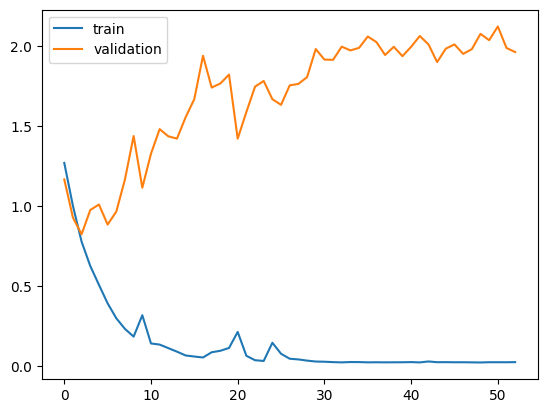

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# 모델

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

## 1) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 Score :', f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.62      0.87      0.73       317
           1       0.59      0.35      0.44       147
           2       0.66      0.53      0.59       146
           3       0.73      0.60      0.66       112
           4       1.00      0.05      0.10        20

    accuracy                           0.64       742
   macro avg       0.72      0.48      0.50       742
weighted avg       0.65      0.64      0.62       742

[[277  15  18   7   0]
 [ 74  51  14   8   0]
 [ 59   4  78   5   0]
 [ 28  10   7  67   0]
 [  6   7   1   5   1]]
Accuracy : 0.6388140161725068
F1 Score : 0.5013793709318174


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 2) SVC

In [ ]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 Score :', f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75       317
           1       0.66      0.44      0.53       147
           2       0.69      0.59      0.64       146
           3       0.79      0.72      0.75       112
           4       0.89      0.40      0.55        20

    accuracy                           0.69       742
   macro avg       0.74      0.60      0.64       742
weighted avg       0.69      0.69      0.68       742

[[272  18  19   8   0]
 [ 61  65  12   8   1]
 [ 54   3  86   3   0]
 [ 17   7   7  81   0]
 [  3   6   0   3   8]]
Accuracy : 0.6900269541778976
F1 Score : 0.6444172094167108


## 3) LGBM

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=2023)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 Score :', f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74       317
           1       0.56      0.41      0.48       147
           2       0.73      0.55      0.63       146
           3       0.75      0.65      0.70       112
           4       1.00      0.20      0.33        20

    accuracy                           0.66       742
   macro avg       0.74      0.54      0.58       742
weighted avg       0.67      0.66      0.65       742

[[275  18  15   9   0]
 [ 68  61  10   8   0]
 [ 54   9  80   3   0]
 [ 25  11   3  73   0]
 [  1  10   1   4   4]]
Accuracy : 0.6644204851752021
F1 Score : 0.5758309300540339


## 4) RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=2023)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 Score :', f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.55      0.91      0.69       317
           1       0.51      0.22      0.30       147
           2       0.74      0.42      0.54       146
           3       0.80      0.46      0.58       112
           4       1.00      0.10      0.18        20

    accuracy                           0.59       742
   macro avg       0.72      0.42      0.46       742
weighted avg       0.63      0.59      0.55       742

[[290  14  11   2   0]
 [ 99  32   8   8   0]
 [ 81   3  62   0   0]
 [ 49  10   2  51   0]
 [ 10   4   1   3   2]]
Accuracy : 0.5889487870619946
F1 Score : 0.4581670344251288
